In [2]:
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import re

# Getting real estate listings


## Zumber

In [3]:
def Zumber(content): 
    soup = BeautifulSoup(content, "html.parser")
    PostalCode =  [x.text.replace(',', '').strip() for x in soup.find_all("span", class_="css-wmtwp4")]
    rent = [x.text for x in soup.find_all("div", class_="css-uzc059")]
    bed_bath = [x.text for x in soup.find_all("div", class_="css-1iq6kk8")]
    dateListed = [x.text for x in soup.find_all('div', 'css-174pdh3')]
    bed,bath = [x.split('•')[0] for x in bed_bath],  [x.split('•')[1] for x in bed_bath]


    dict = {'DateListed': dateListed, 'PostalCode':PostalCode,'Monthly': rent,  'Number of beds': bed, 'Number of baths': bath}
    df= pd.DataFrame(dict)
    df.loc[df['Monthly'].astype(str).str.contains('%'), 'Monthly'] = df['Monthly'].astype(str).str[:6]
    
    df['Monthly'] = df['Monthly'].apply(lambda x:x.replace('$','').replace(',','').replace("+",'').strip())
    df['Monthly']= df['Monthly'].replace({'K':'*1e3'}, regex=True).map(pd.eval)
    return df

### Studios

In [4]:
URL = "https://www.zumper.com/apartments-for-rent/vancouver-bc/west-end/studios"
requestURL = requests.get(URL)
content = requestURL.content

In [5]:
zumber0 = Zumber(content)

### 1 bed

In [6]:
URL2 = "https://www.zumper.com/apartments-for-rent/vancouver-bc/west-end/1-beds"
requestURL2 = requests.get(URL2)
content2 = requestURL2.content

In [7]:
zumber1= Zumber(content2)

## 2 Beds

In [8]:
URL3 = "https://www.zumper.com/apartments-for-rent/vancouver-bc/west-end/2-beds"
requestURL3 = requests.get(URL3)
content3 = requestURL3.content


In [9]:
zumber2 = Zumber(content3)

### 3 beds

In [10]:
URL4 = "https://www.zumper.com/apartments-for-rent/vancouver-bc/west-end/3-beds"
requestURL4 = requests.get(URL4)
content4 = requestURL4.content


In [11]:
zumber3 = Zumber(content4)

# Evaluation

In [12]:
mainZumberDF = pd.concat([zumber0, zumber1, zumber2, zumber3])

In [13]:
mainZumberDF = pd.concat([zumber0, zumber1, zumber2, zumber3])
mainZumberDF['Number of baths'] = mainZumberDF['Number of baths'].str.split(" ")
mainZumberDF['Number of beds'] = mainZumberDF['Number of beds'].str.split(" ")

mainZumberDF['Number of baths'] = mainZumberDF['Number of baths'].str[1]
mainZumberDF['Number of beds'] = mainZumberDF['Number of beds'].str[0]
mainZumberDF



,DateListed,PostalCode,Monthly,Number of beds,Number of baths
0,2d ago,V6G 1P5,1900.0,Studio,1
1,17h ago,V6E 1H1,2700.0,Studio,1
2,1d ago,V6G 1G2,2500.0,Studio,1
3,1d ago,V6G 0C4,2095.0,Studio,1
4,1d ago,V6G 2A1,2200.0,Studio,1
...,...,...,...,...,...
19,5d+ ago,V6G 3H7,8500.0,3,2
20,5d+ ago,V6B 3E1,6700.0,3,3
21,1d ago,V6Z 1C3,8000.0,3,3
22,5d+ ago,V6G 3J6,5500.0,3,2


In [14]:
import seaborn as sns

<AxesSubplot: xlabel='Number of beds', ylabel='Monthly'>

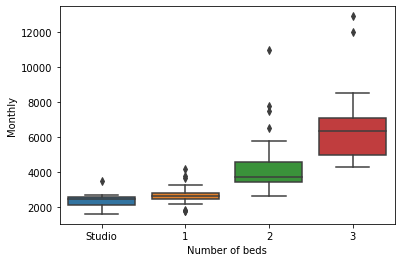

In [15]:
sns.boxplot(x='Number of beds', y='Monthly', data= mainZumberDF)

## Kijiji

In [16]:
def kijiji(content): 
    soup = BeautifulSoup(content, "lxml")
    realEstate = soup.findAll("div", class_="container-results large-images")[1]
    realEstate2 = [x.find('div', class_="info") for x in realEstate.findAll("div", attrs={"data-listing-id":True})]

    realEstateLinks = [x.find('div', class_=["title"]) for x in realEstate2]
    realEstateLinks1 = [x.find('a', attrs={"href":True}) for x in realEstate2]
    realEstateLinks = ["https://www.kijiji.ca"+ x['href'] for x in realEstateLinks1]

    dfKijiji = pd.DataFrame(columns=['DateListed','Postal Code','Monthly', 'Number of beds', 'Number of baths', 'square_feet'])
    squareFeetTotal = []
    for i in range(len(realEstateLinks)):
        requestsIterate = requests.get(realEstateLinks[i])
        soup3 = BeautifulSoup(requestsIterate.text, "html.parser")

        squareFeetInfo = [x.find('dd', class_="twoLinesValue-2815147826").text for x in soup3.find_all('li', class_="twoLinesAttribute-2286252302")]
        for x in soup3.find_all('div', class_=['realEstateTitle-1440881021']):
            monthlyNum = x.find('span').text
            bedAndBath = [section.text for section in x.findAll('span', class_='noLabelValue-3861810455')]
            bedroomNum,bathroomNum = bedAndBath[1], bedAndBath[2]
            if x.find('time') is not None: 
                DateListed = x.find('time').text
            else:
                DateListed = ""
            if bool(re.match('V[0-9][A-Z] [0-9][A-Z][0-9]', x.find('span', class_="address-3617944557").text[-7:])):
                PostalCode = x.find('span', class_="address-3617944557").text[-7:]
            else:
                PostalCode = ""
            dfKijiji = dfKijiji.append({'DateListed':DateListed, 'Postal Code':PostalCode, 'Monthly': monthlyNum, 'Number of beds': bedroomNum,  'Number of baths': bathroomNum}, ignore_index=True)
        if len(squareFeetInfo) > 3:
            squareFeetTotal.append(squareFeetInfo[3])
    dfKijiji['square_feet']= squareFeetTotal
    
    
    dfKijiji = dfKijiji.replace({'Number of beds': 'Bedrooms: Bachelor/Studio', 'Number of baths': 'Bathrooms: '}, 
    {'Number of beds': 'Studio', 'Number of baths': ''}, regex=True)

    dfKijiji['Number of baths'] = dfKijiji['Number of baths'] + " baths"

    dfKijiji['Monthly'] = dfKijiji['Monthly'].apply(lambda x:x.replace('$','').replace(',','').replace("+",'').strip())
    dfKijiji = dfKijiji[dfKijiji.Monthly != "Please Contact"]
    dfKijiji['Monthly']= dfKijiji['Monthly'].replace({'K':'*1e3'}, regex=True).map(pd.eval)
    return dfKijiji
    



### Studios

In [17]:
URL2 = "https://www.kijiji.ca/b-apartments-condos/vancouver-downtown-west-end/bachelor+studio/c37l1700292a27949001"
requestURL2 = requests.get(URL2)
content2 = requestURL2.content

In [18]:
kijijiStudios = kijiji(content2)

### 1 bedroom

In [19]:
URL2 = "https://www.kijiji.ca/b-apartments-condos/vancouver-downtown-west-end/1+bedroom/c37l1700292a27949001"
requestURL2 = requests.get(URL2)
contentOneBedRoom = requestURL2.content

In [20]:
kijijiOne = kijiji(contentOneBedRoom)

### 2 bed

In [29]:
URL2 = "https://www.kijiji.ca/b-apartments-condos/vancouver-downtown-west-end/2+bedrooms/c37l1700292a27949001"
requestURL2 = requests.get(URL2)
contentTwoBedRoom = requestURL2.content

In [30]:
kijijiTwo = kijiji(contentTwoBedRoom)

### 3 bed

In [31]:
URL2 = "https://www.kijiji.ca/b-apartments-condos/vancouver-downtown-west-end/3+bedrooms/c37l1700292a27949001"
requestURL2 = requests.get(URL2)
contentThreeBedRoom = requestURL2.content

In [32]:
kijijiThree = kijiji(contentThreeBedRoom)

In [33]:

mainKijiji = pd.concat([kijijiStudios, kijijiOne, kijijiTwo, kijijiThree])
mainKijiji['Number of baths'] = mainKijiji['Number of baths'].str.split(" ")
mainKijiji['Number of beds'] = mainKijiji['Number of beds'].str.split(" ")

mainKijiji['Number of baths'] = mainKijiji['Number of baths'].str[0]
mainKijiji['Number of beds'] = mainKijiji['Number of beds'].str[-1]

mainKijiji

,DateListed,Postal Code,Monthly,Number of beds,Number of baths,square_feet
0,about 16 hours ago,V6E 1L7,2369,Studio,1,455
1,about 11 hours ago,V6E 4S7,2375,Studio,1,Not Available
2,about 16 hours ago,V6E 1L7,2369,Studio,1,455
3,3 days ago,V3J 1M8,2268,Studio,1,440
4,6 days ago,V6E 1C8,2650,Studio,1,500
...,...,...,...,...,...,...
19,,V6Z 1W4,4499,2,2,Limited
20,,V7S 1X8,2500,2,1,No
0,4 days ago,V7V 2Z5,5800,3,2,No
1,22 days ago,,11995,3,3.5,Limited


<AxesSubplot: xlabel='Number of beds', ylabel='Monthly'>

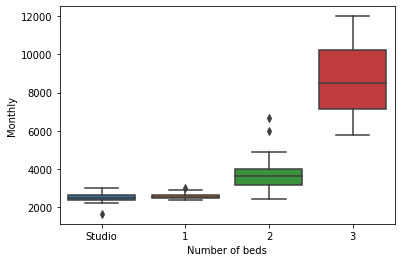

In [34]:
sns.boxplot(x='Number of beds', y='Monthly', data= mainKijiji)

In [35]:
mainKijiji[mainKijiji['Postal Code']=='V6R 2W5']
mainKijiji.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)

## Pad Mapper

In [36]:
import requests
import json

url = "https://www.padmapper.com/api/t/1/pins"

payload = json.dumps({
  "external": True,
  "longTerm": False,
  "maxLat": 49.39453,
  "maxLng": -123.04687,
  "minLat": 49.21875,
  "minLng": -123.22265,
  "minPrice": 0,
  "shortTerm": False,
  "transits": {},
  "limit": 100
})
headers = {
  'Accept': '*/*',
  'Accept-Language': 'en-US,en;q=0.9',
  'Connection': 'keep-alive',
  'Content-Type': 'application/json',
  'Origin': 'https://www.padmapper.com',
  'Pragma': 'no-cache',
  'Sec-Fetch-Dest': 'empty',
  'X-Zumper-XZ-Token': 'qdt1cqxfdc.5rnfdicf6'
}

response = requests.request("POST", url, headers=headers, data=payload)

jsonLoader = json.loads(response.text)


In [37]:
import datetime
from datetime import timedelta

In [38]:

def padMapper(content): 
    #dict = {'DateListed': dateListed, 'PostalCode':PostalCode,'Monthly': rent,  'Number of beds': bed, 'Number of baths': bath}
    #df= pd.DataFrame(dict)
    soupPad = BeautifulSoup(content, "html.parser").find('body')

    infoBubble= soupPad.findAll('script')[1].text
    linksInfo = [x['href'].split("/")[2] for x in soupPad.findAll("a", class_='ListItemMobile_bubbleLink__fWhNX')]
    postalCodes = [x['href'].split("/")[-1][-7:] for x in soupPad.findAll("a", class_='ListItemMobile_bubbleLink__fWhNX')]
    textAdjustment = [int(x.replace('p', '')) for x in linksInfo]
    idToPostal = dict(map(lambda first,second : (first,second) , textAdjustment,postalCodes))
    outPut = [x for x in jsonLoader if x['pb_id'] in textAdjustment]
    df= pd.json_normalize(outPut)
    df['DateListed'] = pd.to_timedelta(df['listed_on'], unit="ms").dt.days.astype(str) + " days ago"
    df['Number of beds'] = df['min_bedrooms']
    df['Number of baths'] = df['min_bathrooms']
    df['Monthly'] = df['min_price']
    df['square_feet'] = df['min_square_feet']
    df['PostalCode'] = df['pb_id']
    df.replace({'PostalCode': idToPostal },inplace=True)
    df['PostalCode'] = df['PostalCode'].apply(str.upper)
    df = df[["DateListed","PostalCode", "Monthly", "Number of beds", "Number of baths", "square_feet"]]
    return df

### Studio 

In [39]:
URL3 = "https://www.padmapper.com/apartments/vancouver-bc/west-end/studios"
requestURL3 = requests.get(URL3)
content3 = requestURL3.content
padStudio = padMapper(content3)

### 1 bathrooms

In [40]:
URL4 = "https://www.padmapper.com/apartments/vancouver-bc/west-end/1-beds"
requestURL4 = requests.get(URL4)
content4 = requestURL4.content

padOne =padMapper(content4)

### 2 bathrooms

In [41]:
URL4 = "https://www.padmapper.com/apartments/vancouver-bc/west-end/2-beds"
requestURL4 = requests.get(URL4)
content4 = requestURL4.content

padTwo = padMapper(content4)

In [42]:
URL4 = "https://www.padmapper.com/apartments/vancouver-bc/west-end/3-beds"
requestURL4 = requests.get(URL4)
content4 = requestURL4.content

padThree = padMapper(content4)

In [43]:
mainPad = pd.concat([padStudio, padOne, padTwo, padThree])

mainPad['Number of beds'] = mainPad['Number of beds'].astype(str)

mainPad['Number of baths'] = mainPad['Number of baths'].astype(str)

In [44]:
mainPad

,DateListed,PostalCode,Monthly,Number of beds,Number of baths,square_feet
0,19 days ago,V6G-1P5,2450,1,1,640
1,19 days ago,V6G-1P5,1900,0,1,418
2,19 days ago,V6E-1L7,2369,0,1,455
3,19 days ago,V6E-2B8,2268,0,1,440
4,19 days ago,V6G-1G6,3000,1,1,629
...,...,...,...,...,...,...
4,19 days ago,V6G-0C6,4500,3,2,1082
5,19 days ago,V6G-1G2,2375,0,1,259
6,19 days ago,V6G-1G2,3300,2,1,512
7,19 days ago,V6G-0C4,2095,0,1,420


<AxesSubplot: xlabel='Number of beds', ylabel='Monthly'>

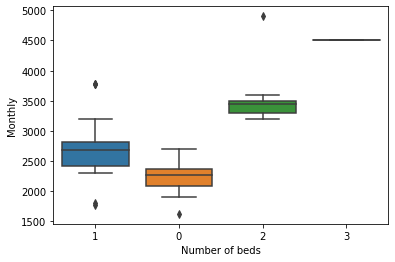

In [45]:
sns.boxplot(x='Number of beds', y='Monthly', data= mainPad)

## Rent cafe

In [46]:
def getLastUpdatedDate(propertyId):
  url = "https://www.rentcafe.com/Preview/Details/{}/?context=Flyout".format(propertyId)

  payload={}
  headers = {
    'authority': 'www.rentcafe.com',
    'accept': '*/*',
    'accept-language': 'en-US,en;q=0.9',
    'Cookie': '__cf_bm=FDpcueUTZpjtex2phw101Fm2Fh6XLL3v2F857RVfk9E-1666315131-0-AX4uocMgJpg1EJIKqvfGhQFzFbJ3txOuWqy83jT/lE6jSDPm3KTkmlQdWh/stfmEQQXl+xhm6s6/CfA1lzgppG8=; PropLeadSource_845951=rentcafe'
  }

  response = requests.request("GET", url, headers=headers, data=payload)

  rentCafePopUpInfo = json.loads(response.text)['data']

  rentCafePopUpInfo = rentCafePopUpInfo.replace("\\r\\n", "");

  rentSoup = BeautifulSoup(rentCafePopUpInfo, "html.parser")
  return [" ".join(x.text.strip().split(" ")[-3:])[:-1] for x in rentSoup.find('p', id="collapseLastUpdatedDateFAQ")]


In [47]:
def rentCafe(content): 
    soup3 = BeautifulSoup(content, "html.parser")
    realEstate = soup3.findAll(["li", "div"], class_=["listing-beds-rent data-rent-ask","data-rent"])
    rentInfo = [x.strip() for x in soup3.findAll("script", type="text/javascript")[4]]
    #lastUpdated = [x.strip() for x in soup3.find("section")]
    rent = [x.text.strip() for x in realEstate]
    
    jsonData = json.loads(rentInfo[0][47:-3])
    baths, beds, PostalCode, area = [], [], [], []
    for i in range(len(jsonData)): 
        baths.append(jsonData[i]['Baths']), beds.append(jsonData[i]['Beds']), PostalCode.append(jsonData[i]['AddressFormatted'][-7:]), area.append(jsonData[i]["Area"])
    
    results = [getLastUpdatedDate(x['PropertyId']) for x in jsonData]
    dateListed = [x[0] for x in results]
    dict = {'DateListed':dateListed, 'PostalCode':PostalCode,'Monthly': rent,  'Number of beds': beds, 'Number of baths': baths, 'Area': area}
    df= pd.DataFrame(dict)
    df = df[df['Monthly'] != "Ask for pricing"]
    df['Monthly'] = df['Monthly'].apply(lambda x:x.replace('$','').replace(',','').replace("+",'').strip()).astype(int)
    df.rename(columns={'Area':'square_feet', 'Postal Code':'PostalCode'})
    return df
   
    

In [48]:
URLCafe1 = "https://www.rentcafe.com/studio-apartments-for-rent/ca/bc/vancouver/west-end-vancouver/"
requestURLCafe1 = requests.get(URLCafe1)
contentCafe1 = requestURLCafe1.content

cafeStudio = rentCafe(contentCafe1)

In [49]:
URLCafe1 = "https://www.rentcafe.com/1-bedroom-apartments-for-rent/ca/bc/vancouver/west-end-vancouver/"
requestURLCafe1 = requests.get(URLCafe1)
contentCafe1 = requestURLCafe1.content

cafeOne = rentCafe(contentCafe1)

In [50]:
URLCafe1 = "https://www.rentcafe.com/2-bedroom-apartments-for-rent/ca/bc/vancouver/west-end-vancouver/"
requestURLCafe1 = requests.get(URLCafe1)
contentCafe1 = requestURLCafe1.content

cafeTwo = rentCafe(contentCafe1)

In [51]:
URLCafe1 = "https://www.rentcafe.com/3-bedroom-apartments-for-rent/ca/bc/vancouver/west-end-vancouver/"
requestURLCafe1 = requests.get(URLCafe1)
contentCafe1 = requestURLCafe1.content

cafeThree = rentCafe(contentCafe1)

In [91]:
mainCafe = pd.concat([cafeStudio, cafeOne, cafeTwo, cafeThree])
mainCafe = mainCafe[mainCafe['Monthly'] != "Ask for pricing"]

mainCafe['Number of baths'] = mainCafe['Number of baths'].str.split(" ")
mainCafe['Number of beds'] = mainCafe['Number of beds'].str.split(" ")

mainCafe['Number of baths'] = mainCafe['Number of baths'].str[0]
mainCafe['Number of beds'] = mainCafe['Number of beds'].str[0]

mainCafe.rename(columns={'Area':'square_feet'}, inplace=True)

mainDF =  mainCafe[mainCafe['Number of beds'] != 0]


In [92]:
mainDF

,DateListed,PostalCode,Monthly,Number of beds,Number of baths,square_feet
3,19 Oct 2022,V5N 1V9,2025,Studio,1,None
4,19 Oct 2022,V7L 3J4,2240,Studio,1,"480 - 1,064 Sq.Ft."
0,18 Oct 2022,V6G 1X4,2175,1,1,450 - 650 Sq.Ft.
1,20 Oct 2022,V6G 2L2,2950,1,1.5,"450 - 1,200 Sq.Ft."
2,15 Oct 2022,V6G 1X3,2350,1,1,450 - 500 Sq.Ft.
4,18 Oct 2022,V6Z 0E7,2800,1,1,497 Sq.Ft.
7,21 Oct 2022,V6B 0P4,2700,1,1,513 Sq.Ft.
8,15 Oct 2022,V5L 2N1,2195,1,1,451 Sq.Ft.
9,17 Oct 2022,V5N 1V9,2275,1,1,None
10,19 Oct 2022,V7L 3J4,2270,1,1,"480 - 1,064 Sq.Ft."


<AxesSubplot: xlabel='Number of beds', ylabel='Monthly'>

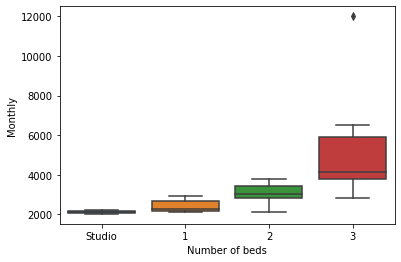

In [93]:
sns.boxplot(x='Number of beds', y='Monthly', data= mainCafe)

In [122]:
allCollected = pd.concat([mainZumberDF,mainDF, mainKijiji, mainPad])
allCollected['PostalCode'] = allCollected['PostalCode'].apply(lambda x:x.replace('-',' '))
allCollected['DateListed'] = allCollected['DateListed'].apply(lambda x:x.replace('h ago',' hours ago').replace('d ago',' days ago'))
allCollected['DateListed'] = allCollected['DateListed'].apply(lambda x:x.replace('about ',''))
allCollected['square_feet'] = allCollected['square_feet'].apply(lambda x:str(x).replace(' Sq.Ft. ',''))

allCollected['Number of beds'] = allCollected['Number of beds'].astype(str)
allCollected['Number of beds'].value_counts()

1         106
2          74
3          36
Studio     32
0          15
Name: Number of beds, dtype: int64

In [123]:
allCollected

,DateListed,PostalCode,Monthly,Number of beds,Number of baths,square_feet
0,2 days ago,V6G 1P5,1900.0,Studio,1,nan
1,17 hours ago,V6E 1H1,2700.0,Studio,1,nan
2,1 days ago,V6G 1G2,2500.0,Studio,1,nan
3,1 days ago,V6G 0C4,2095.0,Studio,1,nan
4,1 days ago,V6G 2A1,2200.0,Studio,1,nan
...,...,...,...,...,...,...
4,19 days ago,V6G 0C6,4500.0,3,2,1082
5,19 days ago,V6G 1G2,2375.0,0,1,259
6,19 days ago,V6G 1G2,3300.0,2,1,512
7,19 days ago,V6G 0C4,2095.0,0,1,420


<AxesSubplot: xlabel='Number of beds', ylabel='Monthly'>

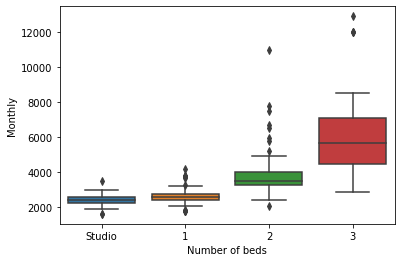

In [124]:

allCollected =  allCollected[allCollected['Number of beds'] != "0"]

sns.boxplot(x='Number of beds', y='Monthly', data= allCollected)

In [125]:
import numpy as np

def removalOutliers(group):

    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3-q1
    lower  = q1-1.5*iqr
    upper = q3+1.5*iqr

    print(lower, upper)
    return ~group.between(lower, upper)

In [126]:
allCollected.reset_index(inplace=True, drop=True)


In [127]:
allCollected

,DateListed,PostalCode,Monthly,Number of beds,Number of baths,square_feet
0,2 days ago,V6G 1P5,1900.0,Studio,1,nan
1,17 hours ago,V6E 1H1,2700.0,Studio,1,nan
2,1 days ago,V6G 1G2,2500.0,Studio,1,nan
3,1 days ago,V6G 0C4,2095.0,Studio,1,nan
4,1 days ago,V6G 2A1,2200.0,Studio,1,nan
...,...,...,...,...,...,...
243,19 days ago,V6G 2C4,3775.0,1,1,627
244,19 days ago,V6G 0C6,2695.0,1,1,630
245,19 days ago,V6G 0C6,4500.0,3,2,1082
246,19 days ago,V6G 1G2,3300.0,2,1,512


In [128]:
allCollected

,DateListed,PostalCode,Monthly,Number of beds,Number of baths,square_feet
0,2 days ago,V6G 1P5,1900.0,Studio,1,nan
1,17 hours ago,V6E 1H1,2700.0,Studio,1,nan
2,1 days ago,V6G 1G2,2500.0,Studio,1,nan
3,1 days ago,V6G 0C4,2095.0,Studio,1,nan
4,1 days ago,V6G 2A1,2200.0,Studio,1,nan
...,...,...,...,...,...,...
243,19 days ago,V6G 2C4,3775.0,1,1,627
244,19 days ago,V6G 0C6,2695.0,1,1,630
245,19 days ago,V6G 0C6,4500.0,3,2,1082
246,19 days ago,V6G 1G2,3300.0,2,1,512


In [129]:
print(allCollected.groupby('Number of beds')['Monthly'].min(),
allCollected.groupby('Number of beds')['Monthly'].max())

Number of beds
1         1775.0
2         2100.0
3         2850.0
Studio    1625.0
Name: Monthly, dtype: float64 Number of beds
1          4200.0
2         11000.0
3         12900.0
Studio     3500.0
Name: Monthly, dtype: float64


In [130]:
allCollected['Number of beds'].value_counts()

1         106
2          74
3          36
Studio     32
Name: Number of beds, dtype: int64

# Outliers removed and anomalies are removed

<AxesSubplot: xlabel='Number of beds', ylabel='Monthly'>

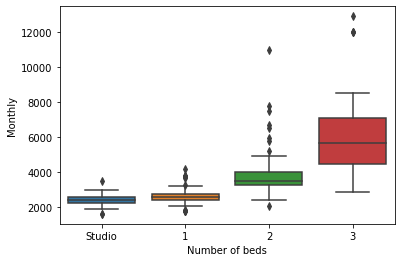

In [131]:
sns.boxplot(x='Number of beds', y='Monthly', data= allCollected)

In [132]:
allCollected.reset_index(inplace=True, drop=True)

In [133]:
allCollected

,DateListed,PostalCode,Monthly,Number of beds,Number of baths,square_feet
0,2 days ago,V6G 1P5,1900.0,Studio,1,nan
1,17 hours ago,V6E 1H1,2700.0,Studio,1,nan
2,1 days ago,V6G 1G2,2500.0,Studio,1,nan
3,1 days ago,V6G 0C4,2095.0,Studio,1,nan
4,1 days ago,V6G 2A1,2200.0,Studio,1,nan
...,...,...,...,...,...,...
243,19 days ago,V6G 2C4,3775.0,1,1,627
244,19 days ago,V6G 0C6,2695.0,1,1,630
245,19 days ago,V6G 0C6,4500.0,3,2,1082
246,19 days ago,V6G 1G2,3300.0,2,1,512
